In [21]:
# Imports
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import joblib
import json
import warnings
warnings.filterwarnings("ignore")

In [22]:
# Load the dataset
df = pd.read_csv("dataset/Beijing_PM2.5_pollution.csv")
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [23]:
# Shape Dataset 
print("Dimensions:", df.shape)

Dimensions: (43824, 13)


In [24]:
# General info
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [25]:
# Check missing values
print("Missing values:")
print(df.isna().sum())

Missing values:
No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64


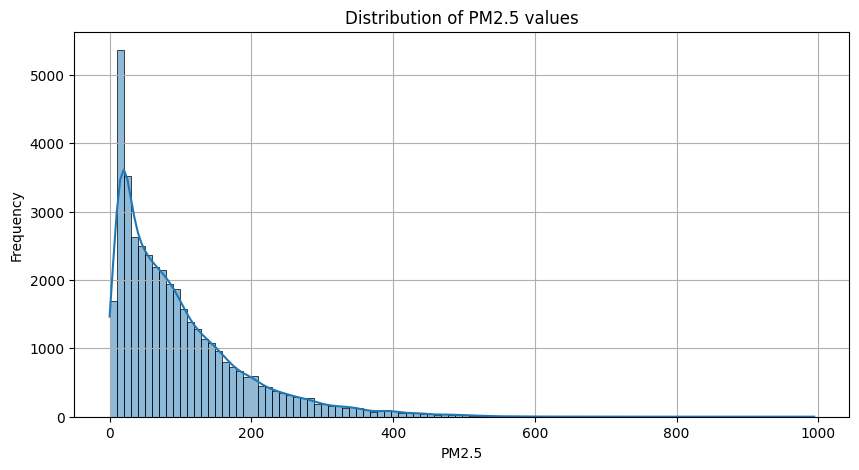

In [26]:
# Check distribution of target
plt.figure(figsize=(10, 5))
sns.histplot(df["pm2.5"], bins=100, kde=True)
plt.title("Distribution of PM2.5 values")
plt.xlabel("PM2.5")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

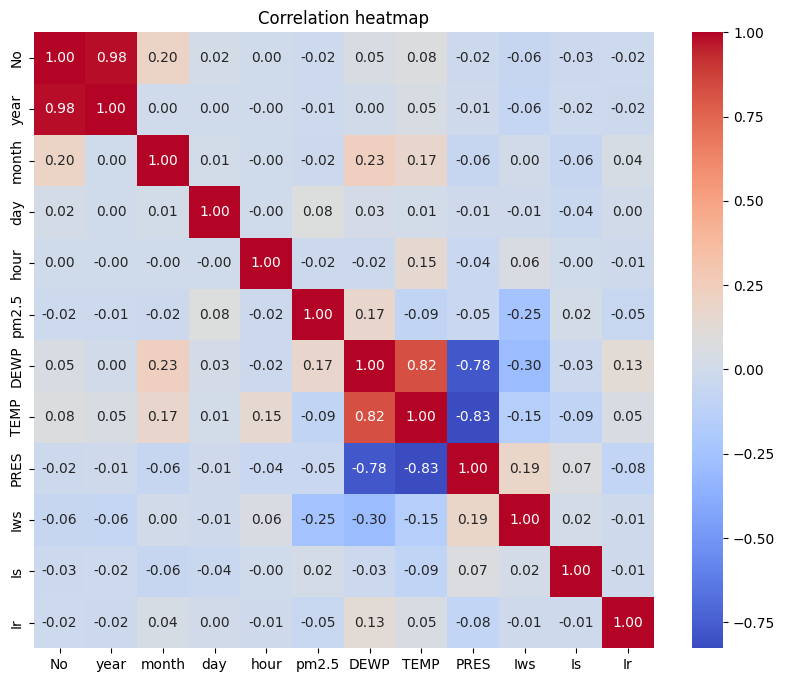

In [27]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=["number"])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap")
plt.show()

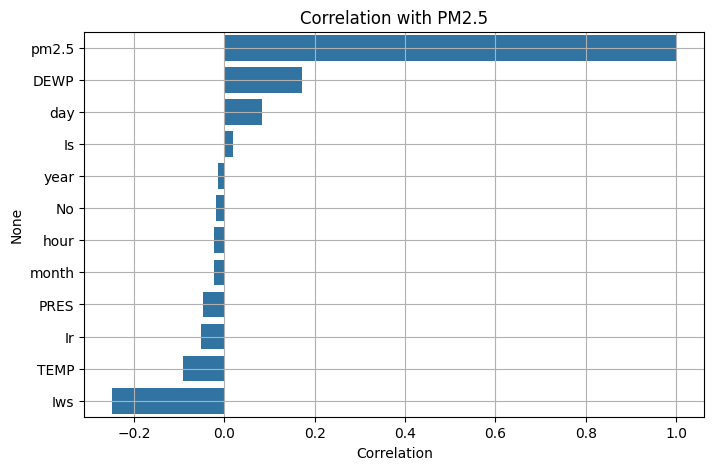

In [28]:
# Correlation with the target variable pm2.5
corr_target = numeric_df.corr()["pm2.5"].sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=corr_target.values, y=corr_target.index)
plt.title("Correlation with PM2.5")
plt.xlabel("Correlation")
plt.grid(True)
plt.show()

In [29]:
# Clean data
df = df[["year", "month", "day", "hour", "pm2.5", "DEWP", "TEMP", "PRES", "cbwd", "Iws", "Is", "Ir"]]
df["pm2.5"] = df["pm2.5"].ffill()

# Feature Engineering
# Lag features
df["pm2.5_lag1"] = df["pm2.5"].shift(1)
df["pm2.5_lag2"] = df["pm2.5"].shift(2)

# Moving averages
df["pm2.5_ma3"] = df["pm2.5"].rolling(window=3).mean()
df["pm2.5_ma6"] = df["pm2.5"].rolling(window=6).mean()
df["pm2.5_ma12"] = df["pm2.5"].rolling(window=12).mean()

# Temporal features
df["dayofweek"] = pd.to_datetime(df[["year", "month", "day"]]).dt.dayofweek

# Interaction term
df["temp_iws"] = df["TEMP"] * df["Iws"]

In [30]:
# Remove rows with NaN
df.dropna(inplace=True)

# Define target and features
X = df.drop(columns=["pm2.5"])
y = df["pm2.5"]

In [31]:
# Preprocessing
categorical = ["cbwd"]
numerical = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical),
    ("num", StandardScaler(), numerical)
])

In [32]:
# Base Model
def train_model(X_train, X_test, y_train, y_test):
    model = LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.03,
        max_depth=12,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return pipeline, y_pred, rmse, mae, r2

In [33]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (35031, 18)
Test set: (8758, 18)


In [34]:
# Train & Evaluate
pipeline, y_pred, rmse, mae, r2 = train_model(X_train, X_test, y_train, y_test)

print(f"Résultats:")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2103
[LightGBM] [Info] Number of data points in the train set: 35031, number of used features: 20
[LightGBM] [Info] Start training from score 97.746425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Résultats:
RMSE : 39.09
MAE  : 2.34
R²   : 0.9956


In [35]:
# The first 10 predictions
results = pd.DataFrame({
    "Actual Value": y_test,
    "Predicted Value": y_pred
})

results.head(10)

,Actual Value,Predicted Value
35066,65.0,64.430029
35067,70.0,66.874740
35068,79.0,78.274461
35069,92.0,89.894308
35070,106.0,103.622455
35071,75.0,77.998318
35072,58.0,58.487580
35073,33.0,33.535314
35074,51.0,48.069710
35075,32.0,30.806449


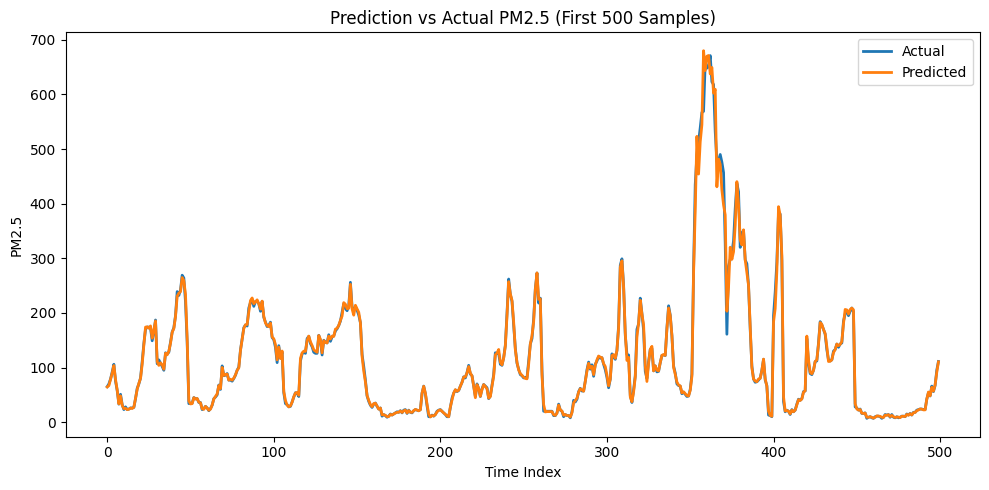

In [36]:
# Actual vs. predicted values curve
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:500], label="Actual", linewidth=2)
plt.plot(y_pred[:500], label="Predicted", linewidth=2)
plt.title("Prediction vs Actual PM2.5 (First 500 Samples)")
plt.xlabel("Time Index")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.show()

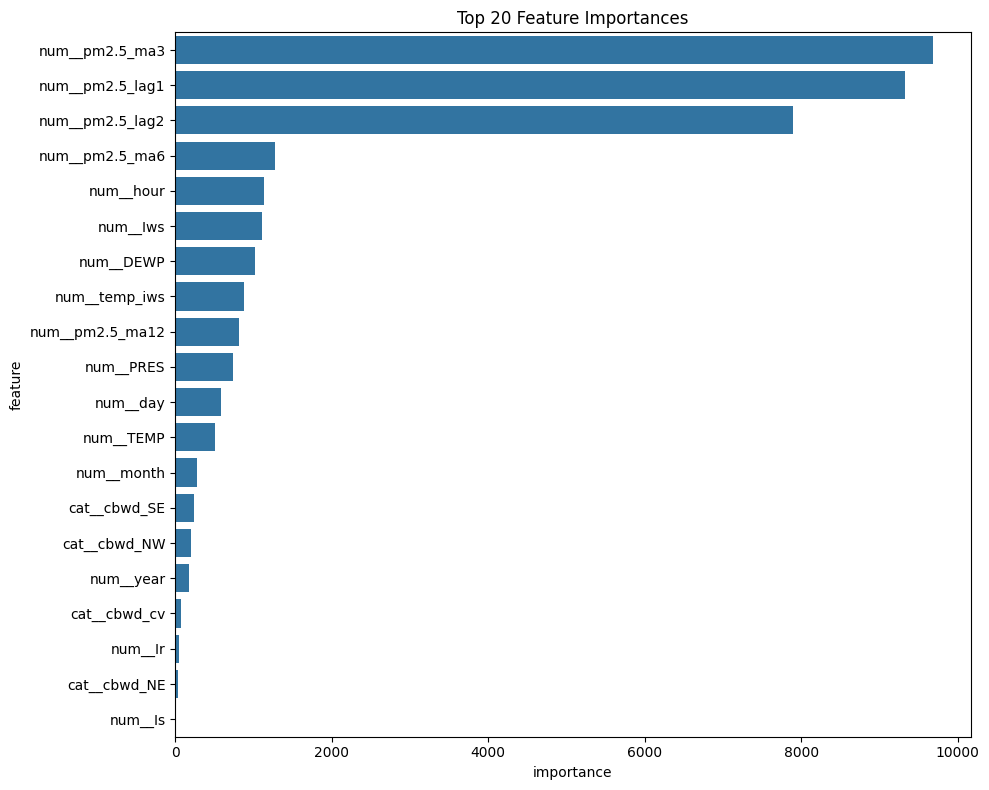

In [37]:
# Feature Importance
model_lgb = pipeline.named_steps["model"]
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
importances = model_lgb.feature_importances_

feat_df = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_df.sort_values("importance", ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(data=feat_df.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

In [38]:
# TimeSeriesSplit Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='r2')
print("TimeSeriesSplit R² scores:", scores)
print(f"Moyenne R² (CV): {scores.mean():.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2074
[LightGBM] [Info] Number of data points in the train set: 7299, number of used features: 19
[LightGBM] [Info] Start training from score 98.784628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [39]:
# Save model
joblib.dump(pipeline, "models/best_model.pkl")
print("Model saved in models/best_model.pkl")

# Save version metadata
metadata = {
    "scikit-learn": sklearn.__version__
}
with open("models/model_metadata.json", "w") as f:
    json.dump(metadata, f)

Model saved in models/best_model.pkl
